<h1 align=center><font size = 5>Exploratory Data Analysis: Boston Startup Ecosystem</font></h1>

## Introduction

In this notebook, we conduct an Exploratory Data Analysis (EDA) of data about Boston Startup Ecosystem collected from the [Foursquare Places API](https://developer.foursquare.com). The idea is to better understand what the startup ecosystem in Paris in order to compare it with others cities. 

[Foursquare Places API](https://developer.foursquare.com) being a geo dataset, the analysis will mainly revolve around geographical analysis and Data Visualization on maps. Our area of investigation will focus on the category and quantity of organizations and companies that are related to startup eosystem. 

Our EDA approach follows the **Data Science Methodology CRISP-DM**. For more info about this approach, check this [Wikipedia page](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Data Collection</a>

2. <a href="#item2">Data Visualization</a>

3. <a href="#item3">Next steps</a>    

</font>
</div>
<a id='the_destination'></a>

First let's download all the libraries required for this notebook.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup # library for web parsing 

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import urllib.request
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 

import folium # map rendering library

from lxml.html import fromstring

print('Libraries imported.')

Libraries imported.


## 1. Data Collection <a id='item1'></a>

#### Define Foursquare Credentials and Version

In [1]:
CLIENT_ID = 'xx' #  Foursquare ID
CLIENT_SECRET = 'xx' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xx
CLIENT_SECRET:xx


#### Category selection

Foursquare has many categories. The full list can be accessed [here](https://developer.foursquare.com/docs/resources/categories). It goes from Restaurants to Stores and some of theses categories can widely impact any analysis just by their shear number of place. As a result, we decided to focus on selected categories that are more directely related to the life of startup, aka a Startup Ecosystem. We use the definition of a [Startup Ecosystem](https://en.wikipedia.org/wiki/Startup_ecosystem) according to Wikipedia.
This list of category is definitely not exhaustive and could evolved based on the result of our analysis or any thoughtfull suggestions. 

Obvisously the first category we selected was **Tech Startup** (4bf58dd8d48988d125941735) as this is the main focus of our analysis.

Then we selected all the services that are required to the common operation of a startup:
- **Coworking Space** (4bf58dd8d48988d174941735)
- **Recruiting Agency** (52f2ab2ebcbc57f1066b8b57)
- **Financial or Legal Service** (503287a291d4c4b30a586d65)
- **Lawyer** (52f2ab2ebcbc57f1066b8b3f)
- **Design Studio** (4bf58dd8d48988d1f4941735)
- **Insurance Office** (58daa1558bbb0b01f18ec1f1)
- **Business Service** (5453de49498eade8af355881)
- **Business Center** (56aa371be4b08b9a8d573517)
- **Advertising Agency** (52e81612bcbc57f1066b7a3d)
- **Bank**	(4bf58dd8d48988d10a951735)
- **Government Building**	(4bf58dd8d48988d126941735)

We also selected the categories related to potential innovation partners of startup:
- **College & University** (4d4b7105d754a06372d81259)
- **Adult Education Center** (56aa371ce4b08b9a8d573570)
- **Laboratory** (5744ccdfe4b0c0459246b4d6)
- **Research Station** (58daa1558bbb0b01f18ec1b2)

We also selected the categories related to potential industrial partners of startup:
- **Industrial Estate** (56aa371be4b08b9a8d5734d7)
- **Factory** (4eb1bea83b7b6f98df247e06)

We also selected the categories related to potential cultural partners of startup:
- **Library** (4bf58dd8d48988d12f941735)
- **Science Museum** (4bf58dd8d48988d191941735)
- **Art Museum** (4bf58dd8d48988d18f941735)
- **History Museum** (4bf58dd8d48988d190941735)
- **Planetarium** (4bf58dd8d48988d192941735)



We then selected the category to various events that are required for startup to network and meet potential users or customers:
- **Events** (4d4b7105d754a06373d81259) 
- **Trade Fair**	(5bae9231bedf3950379f89c3)

The full list of categories was compiled in a csv file avaliable [here](https://raw.githubusercontent.com/MattSonnati/Data_Science_Coursera_Capstone/master/startup_ecosystem_category_list.csv)

In [3]:
startup_ecosystem_category_list = pd.read_csv('https://raw.githubusercontent.com/MattSonnati/where_is_the_french_silicon_valley/master/startup_ecosystem_category_list.csv').dropna()
startup_ecosystem_category_list

,4sq_category_name,4sq_id,color_code
0,Tech Startup,4bf58dd8d48988d125941735,#32CD32
1,Coworking Space,4bf58dd8d48988d174941735,#ADFF2F
2,Insurance Office,58daa1558bbb0b01f18ec1f1,#FFD700
3,Recruiting Agency,52f2ab2ebcbc57f1066b8b57,#FFFFE0
4,Financial or Legal Service,503287a291d4c4b30a586d65,#FFE4B5
5,Lawyer,52f2ab2ebcbc57f1066b8b3f,#FFFF00
6,Laboratory,5744ccdfe4b0c0459246b4d6,#87CEFA
7,College & University,4d4b7105d754a06372d81259,#00BFFF
8,Adult Education Center,56aa371ce4b08b9a8d573570,#6495ED
9,Research Station,58daa1558bbb0b01f18ec1b2,#4169E1


#### Area selection

In many instance, the geographical area referred to by poiting at a specific city is much wider than the administrative boundaries of said city. For example when people talk about startup from the "Bay area", SF or the Silicon Valley, in fact they refer to several cities from San Fransisco, Palo alto, Mountain view up to San Jose. 

Boston startup ecosystem is also known as the [Route 128](https://en.wikipedia.org/wiki/Massachusetts_Route_128) (now part of I-95). This area hosts Harvard University and MIT, among other major tech companies. According to UC Berkeley Professor [AnnaLee Saxenian](https://hbr.org/2014/12/what-still-makes-silicon-valley-so-special), this area is very interesting to look at when trying to understand what makes Silicon Valley so special.

We thus ask Foursquare API to find all the City (50aa9e094b90af0d42d5de0d) within 50000 meters from Boston, MA. 

In [4]:
address_near = "Boston, MA"
radius = 50000
category_id = "50aa9e094b90af0d42d5de0d"

In [5]:
# function that extracts the category name of the venue
def get_category_name(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venues.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    # function that extracts the category of the venue
def get_category_id(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venues.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['id']
    
#create the GET request URL
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)

# Send the GET request 
results = requests.get(url).json()

# Convert the JSON response into a dataframe
cities = results['response']['venues']
cities_list = json_normalize(cities) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.postalCode',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
cities_list =cities_list.loc[:, filtered_columns]

# filter the category for each row
cities_list['primary_category_name'] = cities_list.apply(get_category_name, axis=1)
cities_list['primary_category_id'] = cities_list.apply(get_category_id, axis=1)

# clean columns
cities_list.columns = [col.split(".")[-1] for col in cities_list.columns]

cities_list.head()

,name,id,postalCode,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,City of Boston,4c3b455b4565e21eb76c566a,02109,Massachusetts,United States,US,42.361081,-71.059656,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",City,50aa9e094b90af0d42d5de0d
1,"Cambridge, MA",4da5796cf7b16ce044a3f99a,02139,Massachusetts,United States,US,42.374382,-71.105919,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",City,50aa9e094b90af0d42d5de0d
2,"Waltham, MA",4c924e507f3b8cfab50ea41e,02453,Massachusetts,United States,US,42.376816,-71.236293,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",City,50aa9e094b90af0d42d5de0d
3,"Burlington, MA",4e599df3b993732579ec9c72,01803,Massachusetts,United States,US,42.504993,-71.195869,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",City,50aa9e094b90af0d42d5de0d
4,"Somerville, MA",4d4eb9438af6721ef5371388,02145,Massachusetts,United States,US,42.388464,-71.095167,"[{'id': '50aa9e094b90af0d42d5de0d', 'name': 'C...",City,50aa9e094b90af0d42d5de0d


In [6]:
cities_list.shape

(50, 11)

In [7]:
# Save dataframe as csv file to localhost
cities_list.to_csv(r'boston_cities_list.csv')

# Save dataframe as csv file to Watson studio (need token)
# project.save_data(data=cities_list.to_csv(index=False),file_name='boston_cities_list.csv',overwrite=True)

#### List of Startup Ecosystem places in Boston area

For each city in the chosen area, we list all the places in our Category selection and within 5 km of said city. 

In [8]:
def getCategoryVenues(name, latitude, longitude, radius, category_id):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION,
    radius, 
    LIMIT,
    category_id)

    # Send the GET request 
    results = requests.get(url).json()

    # Convert the JSON response into a dataframe
    category_venues = results['response']['venues']
    category_venues_list = json_normalize(category_venues) # flatten JSON

    # filter columns
    filtered_columns = ['name',
                            'id',
                            'location.postalCode',
                            'location.state',
                            'location.country',
                            'location.cc',
                            'location.lat', 
                            'location.lng',
                            'categories',]
    category_venues_list = category_venues_list.loc[:, filtered_columns]

    # filter the category for each row
    category_venues_list['primary_category_name'] = category_venues_list.apply(get_category_name, axis=1)
    category_venues_list['primary_category_id'] = category_venues_list.apply(get_category_id, axis=1)

    # clean columns
    category_venues_list.columns = [col.split(".")[-1] for col in category_venues_list.columns]

    return(category_venues_list)
    

In [9]:
radius = 5000
startup_ecosystem_place_list = pd.DataFrame(columns=['name','id','city','postalCode','state','country','cc','lat','lng','categoriesList','primary_category_name','primary_category_id'])

for category_name, category_id, color_code  in zip(startup_ecosystem_category_list['4sq_category_name'],
                                          startup_ecosystem_category_list['4sq_id'],
                                          startup_ecosystem_category_list['color_code']):
   
    for latitude, longitude, name  in zip(cities_list['lat'],
                                          cities_list['lng'],
                                          cities_list['name']):
        try:
            startup_ecosystem_place_list = pd.concat([startup_ecosystem_place_list, getCategoryVenues(name, latitude, longitude, radius, category_id)], sort=True)
        except:
            pass

startup_ecosystem_place_list.drop_duplicates(subset=['id'], keep='first', inplace=True)
startup_ecosystem_place_list.head()

/Users/Matt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,categories,categoriesList,cc,city,country,id,lat,lng,name,postalCode,primary_category_id,primary_category_name,state
0,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T...",NaN,US,NaN,United States,53b16953498e81285144c0e8,42.347197,-71.078305,Wayfair Office,02116,4bf58dd8d48988d125941735,Tech Startup,MA
1,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T...",NaN,US,NaN,United States,548f0e7c498ee06c32805296,42.355950,-71.052410,DataRobot,02110,4bf58dd8d48988d125941735,Tech Startup,MA
2,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",NaN,US,NaN,United States,569e69da498ef17cd8221185,42.370132,-71.076272,HubSpot,02141,4bf58dd8d48988d124941735,Office,MA
3,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",NaN,US,NaN,United States,4a60d55af964a52040c11fe3,42.369746,-71.077678,HubSpot,02141,4bf58dd8d48988d124941735,Office,MA
4,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T...",NaN,US,NaN,United States,53b3fd51498eedf328db817b,42.344895,-71.103175,Toast Inc,02215,4bf58dd8d48988d125941735,Tech Startup,MA


In [10]:
startup_ecosystem_place_list.shape

(9301, 13)

In [11]:
# Save dataframe as csv file to localhost
startup_ecosystem_place_list.to_csv(r'boston_startup_ecosystem_place_list.csv')

# Save dataframe as csv file to Watson studio (need token)
# project.save_data(data=startup_ecosystem_place_list.to_csv(index=False),file_name='boston_startup_ecosystem_place_list.csv',overwrite=True)

## 2. Data Visualization <a id='item2'></a>

First, let define a function to creat map from a list of Place based on their latitude and longitude coordinate.

In [12]:
def getMap(centerPlace, venues_list):

    # create a user agent
    geolocator = Nominatim(user_agent="fr_explorer")

    address = centerPlace
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    # create map using latitude and longitude values
    map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

    # add markers to map
    for lat, lng, name, postalCode  in zip(venues_list['lat'], 
                                                          venues_list['lng'], 
                                                          venues_list['name'], 
                                                          venues_list['postalCode']):
        label = '{} {}'.format(name, postalCode)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venues)  

    return(map_venues)

Map of cities within 50 km from Boston, MA

In [13]:
 getMap('Boston, MA', cities_list)

#### To better understand Boston Startup Ecosystem, we can take a look at the number of place in each categories.

In order to better visualize these data, we can plot them as a horizontal bar plot.

In [14]:
count_per_category = startup_ecosystem_place_list.groupby('primary_category_name').count()
count_per_category.drop(['categories','categoriesList','state','postalCode','city'], axis=1, inplace=True)
count_per_category.sort_values(['id'], ascending=True, axis=0, inplace=True)
count_per_category

,cc,country,id,lat,lng,name,primary_category_id
primary_category_name,,,,,,,
Gun Shop,1,1,1,1,1,1,1
Moving Target,1,1,1,1,1,1,1
Military Base,1,1,1,1,1,1,1
Men's Store,1,1,1,1,1,1,1
Meeting Room,1,1,1,1,1,1,1
Marijuana Dispensary,1,1,1,1,1,1,1
Locksmith,1,1,1,1,1,1,1
Line / Queue,1,1,1,1,1,1,1
Laundry Service,1,1,1,1,1,1,1


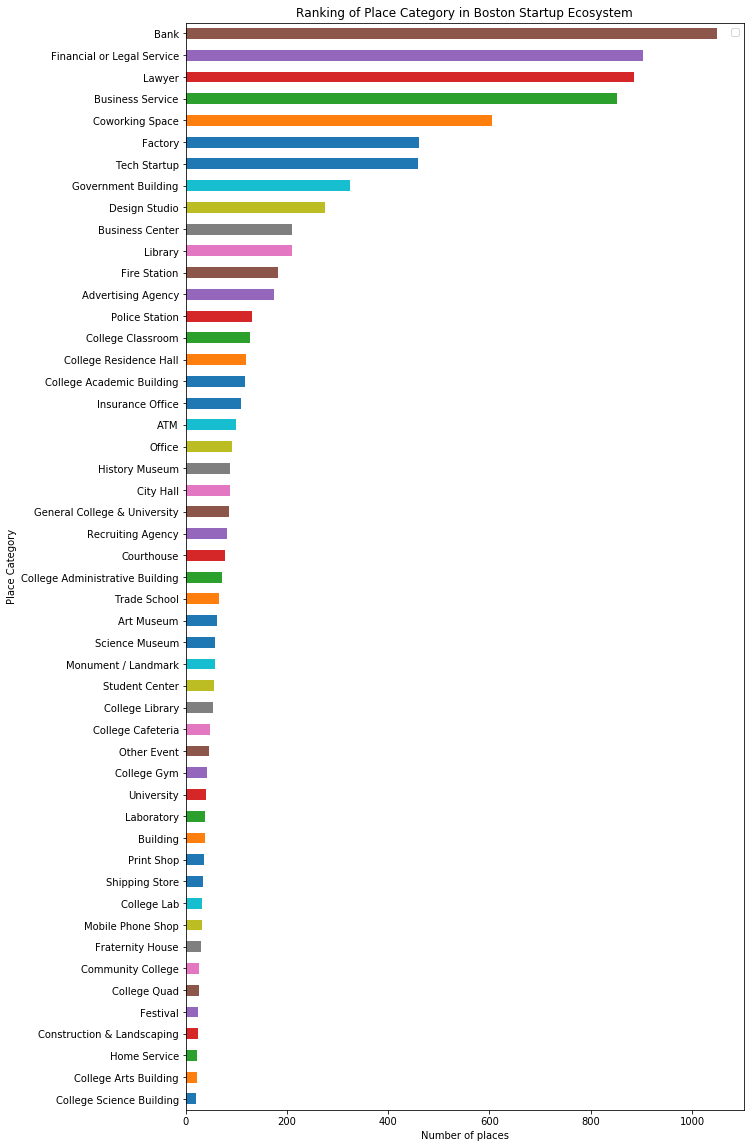

In [15]:
# plot data
count_per_category['id'].tail(50).plot(kind='barh', figsize=(10, 20))

plt.xlabel('Number of places') # add to x-label to the plot
plt.ylabel('Place Category') # add y-label to the plot
plt.title('Ranking of Place Category in Boston Startup Ecosystem') # add title to the plot
plt.legend('') # add title to the plot

plt.show()

## 3. Next Steps <a id='item3'></a>

In this notebook, we have collected data about Boston Startup Ecosystem. We then had a quick glance about the data through a map and an histogram. These data will be combined with others similar data from other Startup Ecosystem in the world then analyzed in a subsequent notebook. Then we will try to compare and identify similarity among these Startup Ecosystem through machine learning clustering techniques.

<hr>

Copyright &copy; 2019 [Matt Sonnati](https://www.linkedin.com/in/matthieusonnati/). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/). 